In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm

In [2]:
insurance_df = pd.read_csv('Data/insurance.csv')
insurance_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
# Feature Engineering
insurance_df = (
    pd.get_dummies(insurance_df, drop_first=True).astype(int)
    .assign(
        age_sq = insurance_df['age'] ** 2,
        smoker_bmi_int = lambda x: x['smoker_yes'] * x['bmi']
    )
)

In [4]:
# Data Splitting
from sklearn.model_selection import train_test_split

X = sm.add_constant(insurance_df.drop(['charges'], axis=1))
y = insurance_df['charges']

X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=2023)
X.head()

,const,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age_sq,smoker_bmi_int
1068,1.0,63,21,1,1,0,1,0,0,3969,0
1018,1.0,54,35,3,0,0,1,0,0,2916,0
995,1.0,39,23,3,0,0,0,0,0,1521,0
1248,1.0,18,39,0,0,0,0,1,0,324,0
549,1.0,43,46,0,0,1,0,1,0,1849,46


In [5]:
# Standardization
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
X_tr = std.fit_transform(X_train.values)
X_val = std.transform(X_valid.values)
X_te = std.transform(X_test.values)

In [6]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=1).fit(X_tr, y_train)
list(zip(X.columns, ridge_model.coef_))

[('const', 0.0),
 ('age', -38.220191187255345),
 ('bmi', 188.18725390185773),
 ('children', 804.2440842685336),
 ('sex_male', -257.6898217301285),
 ('smoker_yes', -7588.798673309465),
 ('region_northwest', -46.144199194630005),
 ('region_southeast', -499.5407165127531),
 ('region_southwest', -546.8370248623995),
 ('age_sq', 3668.3976823186495),
 ('smoker_bmi_int', 17827.229897147645)]

<Axes: xlabel='alpha'>

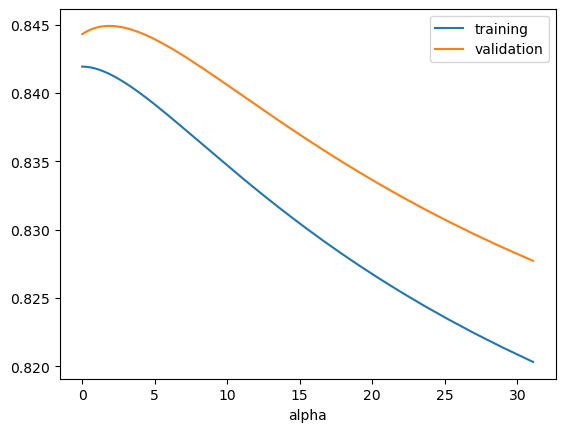

In [7]:
n_alphas = 200
alphas = 10 ** np.linspace(-3, 3, n_alphas)

train_scores = []
val_scores = []

for alpha in alphas:
    ridge_model = Ridge(alpha=alpha).fit(X_tr, y_train)
    train_scores.append(ridge_model.score(X_tr, y_train))
    val_scores.append(ridge_model.score(X_val, y_valid))

scores_df = pd.DataFrame({
    'alpha': alphas,
    'training': train_scores,
    'validation': val_scores
})

scores_df[:150].set_index('alpha').plot() #[:150]

In [8]:
scores_df.sort_values('validation', ascending=False)

,alpha,training,validation
109,1.933892,0.841360,0.844904
108,1.804186,0.841427,0.844904
110,2.072922,0.841286,0.844900
107,1.683180,0.841485,0.844899
106,1.570290,0.841538,0.844891
...,...,...,...
195,757.525026,0.710839,0.726072
196,811.984499,0.702656,0.718046
197,870.359136,0.693919,0.709445
198,932.930403,0.684618,0.700257


In [9]:
std = StandardScaler()
X_m = std.fit_transform(X.values)
X_te = std.transform(X_test.values)

In [10]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=1.933).fit(X_m, y)
list(zip(X.columns, ridge_model.coef_))

[('const', 0.0),
 ('age', -209.7789685373743),
 ('bmi', 198.23528443060837),
 ('children', 795.9933151719246),
 ('sex_male', -157.93659078089763),
 ('smoker_yes', -7006.579378687364),
 ('region_northwest', -2.153322191716462),
 ('region_southeast', -492.8250096493298),
 ('region_southwest', -491.77026690542965),
 ('age_sq', 4012.6649045127097),
 ('smoker_bmi_int', 17186.985029575695)]

In [11]:
ridge_model.score(X_m, y)

0.8427604643244575

In [12]:
ridge_model.score(X_te, y_test)

0.8443605193340842

In [13]:
lr_model = sm.OLS(y, X).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     569.0
Date:                Thu, 09 Oct 2025   Prob (F-statistic):               0.00
Time:                        11:48:59   Log-Likelihood:                -10600.
No. Observations:                1070   AIC:                         2.122e+04
Df Residuals:                    1059   BIC:                         2.128e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             2800.3921   1571.606      1.782      0.075    -283.424    5884.208
age                -40.4601     73.845     -0.548      0.584    -185.359     104.439
bmi                 13.6598     28.474      0.480      0.632     -42.212      69.531
children           686.4746    131.525      5.219      0.000     428.395     944.554
sex_male          -335.4152    300.498     -1.116      0.265    -925.054     254.223
smoker_yes       -1.999e+04   1814.158    -11.019      0.000   -2.35e+04   -1.64e+04
region_northwest   -22.0757    433.380     -0.051      0.959    -872.458     828.306
region_southeast -1108.8816    426.354     -2.601      0.009   -1945.477    -272.286
region_southwest -1164.2106    428.764     -2.715      0.007   -2005.534    -322.887
age_sq               3.8845      0.920      4.221      0.000       2.079       5.690
smoker_bmi_int    1456.0539     58.660     24.822      0.000    1340.950    1571.158
==============================================================================
Omnibus:                      607.486   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4110.058
Skew:                           2.631   Prob(JB):                         0.00
Kurtosis:                      11.031   Cond. No.                     2.68e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.68e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
from sklearn.metrics import r2_score as r2

r2(y_test, lr_model.predict(X_test))

0.8439796669805302

## **RidgeCV**

In [15]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error as mae

n_alphas = 200
alphas = 10 ** np.linspace(-3, 3, n_alphas)

ridge_model = RidgeCV(alphas=alphas, cv=5)
ridge_model.fit(X_m, y)

print(ridge_model.score(X_m, y))
print(mae(y, ridge_model.predict(X_m)))
print(ridge_model.alpha_)

0.8430824596714971
2867.460280277705
0.06905513520162328


In [16]:
ridge_model.score(X_te, y_test)

0.8440074603084418

## **Lasso Regression**

In [17]:
# Standardization
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
X_tr = std.fit_transform(X_train.values)
X_val = std.transform(X_valid.values)
X_te = std.transform(X_test.values)

In [18]:
from sklearn.linear_model import Lasso

lasso_model = Lasso(alpha=1).fit(X_tr, y_train) # Up strength to drop vars
list(zip(X.columns, lasso_model.coef_))

[('const', 0.0),
 ('age', -149.092527659514),
 ('bmi', 108.72184834494719),
 ('children', 809.3480943833656),
 ('sex_male', -260.3478350337834),
 ('smoker_yes', -8311.228490420386),
 ('region_northwest', -47.149699576057664),
 ('region_southeast', -499.8996368784473),
 ('region_southwest', -546.6788501350804),
 ('age_sq', 3781.2908888548304),
 ('smoker_bmi_int', 18561.790175275684)]

<Axes: xlabel='alpha'>

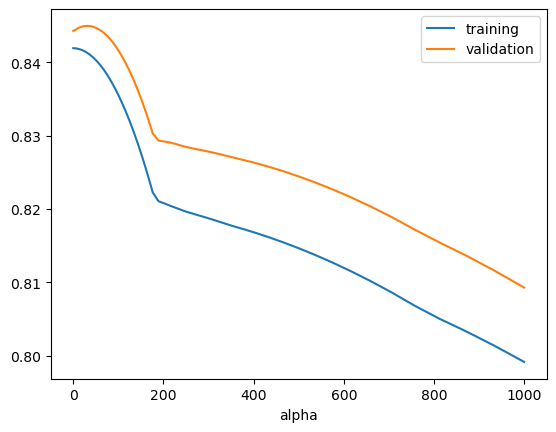

In [19]:
n_alphas = 200
alphas = 10 ** np.linspace(-3, 3, n_alphas)

train_scores = []
val_scores = []

for alpha in alphas:
    lasso_model = Lasso(alpha=alpha).fit(X_tr, y_train)
    train_scores.append(lasso_model.score(X_tr, y_train))
    val_scores.append(lasso_model.score(X_val, y_valid))

scores_df = pd.DataFrame({
    'alpha': alphas,
    'training': train_scores,
    'validation': val_scores
})

scores_df.set_index('alpha').plot() #[:150]

In [20]:
scores_df.sort_values('validation', ascending=False)

,alpha,training,validation
149,31.078662,0.841287,0.844960
148,28.994229,0.841367,0.844957
150,33.312948,0.841195,0.844957
147,27.049597,0.841437,0.844949
151,35.707860,0.841090,0.844945
...,...,...,...
195,757.525026,0.806796,0.817174
196,811.984499,0.805036,0.815434
197,870.359136,0.803337,0.813667
198,932.930403,0.801386,0.811630


In [21]:
lasso_model = Lasso(alpha=31.08).fit(X_m, y)
list(zip(X.columns, lasso_model.coef_))

[('const', 0.0),
 ('age', 0.0),
 ('bmi', 194.83993295174704),
 ('children', 756.1205830110765),
 ('sex_male', -121.74471780145984),
 ('smoker_yes', -6622.358974973235),
 ('region_northwest', 2.4976910557731236),
 ('region_southeast', -431.87339252624554),
 ('region_southwest', -437.02090716249995),
 ('age_sq', 3784.277044326391),
 ('smoker_bmi_int', 16804.947357837395)]

In [22]:
lasso_model.score(X_m, y)

0.842417998497555

In [23]:
lasso_model.score(X_te, y_test)

0.8441393714334857

In [24]:
r2(y_test, lr_model.predict(X_test))

0.8439796669805302

## **LassoCV (Cross Validation)**

In [27]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error as mae

n_alphas = 200
alphas = 10 ** np.linspace(-3, 3, n_alphas)

lasso_model = LassoCV(alphas=alphas, cv=5)
lasso_model.fit(X_m, y)

print(lasso_model.score(X_m, y))
print(mae(y, lasso_model.predict(X_m)))
print(lasso_model.alpha_)

0.8430804246271248
2867.73829126659
1.1097524964120722


In [28]:
lasso_model.score(X_te, y_test)

0.8436037623839141

In [29]:
list(zip(X.columns, lasso_model.coef_))

[('const', 0.0),
 ('age', -458.2537484971006),
 ('bmi', 88.31125525635231),
 ('children', 812.7261992761905),
 ('sex_male', -165.78454054510695),
 ('smoker_yes', -7987.911200194197),
 ('region_northwest', -5.565056402221853),
 ('region_southeast', -493.96913713955934),
 ('region_southwest', -495.51763646090217),
 ('age_sq', 4269.188776504135),
 ('smoker_bmi_int', 18186.37427711678)]

## **Elastic Net**

In [30]:
from sklearn.linear_model import ElasticNet

enet_model = ElasticNet(alpha=1, l1_ratio=0.5).fit(X_tr, y_train)
print(
    f"Train Score: {round(enet_model.score(X_tr, y_train), 4)} "
    f"Valid Score: {round(enet_model.score(X_val, y_valid), 4)} "
)

Train Score: 0.7632 Valid Score: 0.7764 


In [34]:
train_scores = []
val_scores = []

l1_ratios = np.linspace(0.01, 1, 100)

for l1_ratio in l1_ratios:
    enet_model = ElasticNet(alpha=1, l1_ratio=l1_ratio).fit(X_tr, y_train)
    train_scores.append(enet_model.score(X_tr, y_train))
    val_scores.append(enet_model.score(X_val, y_valid))

Text(0.5, 0, 'L1_Ratio')

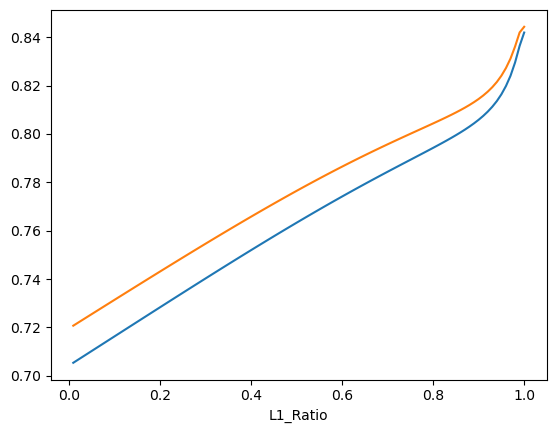

In [35]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(l1_ratios, train_scores, label='Train Scores')
ax.plot(l1_ratios, val_scores, label='Validation Scores')

ax.set_xlabel('L1_Ratio')

In [36]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

l1_ratios = np.linspace(0.01, 1, 100)
alphas = 10 ** np.linspace(-3, 3, n_alphas)

param_grid = {"alpha": alphas, "l1_ratio":l1_ratios}

eNet_model = ElasticNet()
grid = GridSearchCV(eNet_model, param_grid, scoring='r2', cv=5)
grid.fit(X_m, y)

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': array([1.00000000e-03, 1.07189132e-03, 1.14895100e-03, 1.23155060e-03,
       1.32008840e-03, 1.41499130e-03, 1.51671689e-03, 1.62575567e-03,
       1.74263339e-03, 1.86791360e-03, 2.00220037e-03, 2.14614120e-03,
       2.30043012e-03, 2.46581108e-03, 2.64308149e-03, 2.83309610e-03,
       3.03677112e-03, 3.25508860e-03, 3.48910121e-...
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])},
             scoring='r2')

In [37]:
print(f"Best Params: {grid.best_params_}")
print(f"Best Score: {grid.best_score_}")

Best Params: {'alpha': 0.9658832241158698, 'l1_ratio': 1.0}
Best Score: 0.8414050477852086


In [38]:
eNet_final = ElasticNet(alpha=1.11, l1_ratio=1).fit(X_m, y)
eNet_final.score(X_m, y)

0.8430804235179605

In [39]:
eNet_final.score(X_te, y_test)

0.8436037638996834

## **ElasticNetCV**

In [43]:
from sklearn.linear_model import ElasticNetCV

alphas = 10 ** np.linspace(-3, 3, 200)
l1_ratios = np.linspace(.1, 1, 10) # .9, 1, 10

enet_model = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5)
enet_model.fit(X_m, y)

print(enet_model.score(X_m, y))
print(enet_model.score(X_te, y_test))
print(enet_model.alpha_)
print(enet_model.l1_ratio)

0.8430804246271248
0.8436037623839141
1.1097524964120722
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
